Домашнее задание по теме «RFRegressor, Feature engineering»


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,  # Функция для разделения данных на обучающую и тестовую выборки
)
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
# Импорт моделей и инструментов для дерева решений
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd # работа с таблицами
import numpy as np # математические вычисления

%matplotlib inline
import matplotlib.pyplot as plt # визуализация данных
from matplotlib import style  # стиль визуализации данных

plt.rcParams["figure.figsize"] = (10,5) # размер графиков
plt.style.use('fivethirtyeight') # стиль графиков, альтернативный style.use('ggplot')

from sklearn.model_selection import train_test_split  # разделение на тестовую и тренировочную выборки
from sklearn.metrics import classification_report # метрики классификатора

# extract_features - извлечь все признаки, extract_relevant_features - извлечь релевантные признаки
# select_features рассчитывает важность текущего признака для предсказания класса
from tsfresh import extract_features, extract_relevant_features, select_features

from tsfresh.utilities.dataframe_functions import impute # заполнить пропуски, удалите все значения NaN, scikit-learn аналог
from tsfresh.utilities.dataframe_functions import roll_time_series # скользящее окно по данным

# генерация новых признаков
# TimeBasedFCParameters рассчитает линейный тренд, R^2, intercept, slope, стандартную ошибку и p-value добавить расчеты к признакам
from tsfresh.feature_extraction.settings import TimeBasedFCParameters

# MinimalFCParameters рассчитает сумму, медиану, среднее, длину, стандартное отклонение, дисперсию, максимальное и минимальное значения каждого ряда
# EfficientFCParameters рассчитает коэффициенты skewness и kurtosis, повтор минимума и максимума, квантили, оконные статистики, автокорреляции и др
# ComprehensiveFCParameters самый большой и полный вариант, добавляются неэффективные в вычислительном плане признаки, но модель порой обучается лучше
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters, ComprehensiveFCParameters

import plotly.express as px

In [370]:
RAND_STATE = 42

Загружаем данные

In [423]:
train_df=pd.read_csv('train.csv', index_col='id')

In [424]:
pd.options.display.float_format = '{:,.2f}'.format
train_df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
id,,,,,,,,,,,,,,,,,,,,
0,19.00,Female,"10,049.00",Married,1.00,Bachelor's,Self-Employed,22.60,Urban,Premium,2.00,17.00,372.00,5.00,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,"2,869.00"
1,39.00,Female,"31,678.00",Divorced,3.00,Master's,NaN,15.57,Rural,Comprehensive,1.00,12.00,694.00,2.00,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,"1,483.00"
2,23.00,Male,"25,602.00",Divorced,3.00,High School,Self-Employed,47.18,Suburban,Premium,1.00,14.00,NaN,3.00,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.00
3,21.00,Male,"141,855.00",Married,2.00,Bachelor's,NaN,10.94,Rural,Basic,1.00,0.00,367.00,1.00,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.00
4,21.00,Male,"39,651.00",Single,1.00,Bachelor's,Self-Employed,20.38,Rural,Premium,0.00,8.00,598.00,4.00,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,"2,022.00"


In [129]:
train_df.info(memory_usage=True) 

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1181471 non-null  object 
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Policy Start Date     1200000 non-null 

Мы возьмем только часть данных, поэтому можно просто убрать пропуски

In [425]:
train_df = train_df.dropna()
train_df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Index: 384004 entries, 0 to 1199990
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Age                   384004 non-null  float64
 1   Gender                384004 non-null  object 
 2   Annual Income         384004 non-null  float64
 3   Marital Status        384004 non-null  object 
 4   Number of Dependents  384004 non-null  float64
 5   Education Level       384004 non-null  object 
 6   Occupation            384004 non-null  object 
 7   Health Score          384004 non-null  float64
 8   Location              384004 non-null  object 
 9   Policy Type           384004 non-null  object 
 10  Previous Claims       384004 non-null  float64
 11  Vehicle Age           384004 non-null  float64
 12  Credit Score          384004 non-null  float64
 13  Insurance Duration    384004 non-null  float64
 14  Policy Start Date     384004 non-null  object 
 15  Cust

Для работы возьмем 10000 строк из датасета

In [426]:
train_df_part = train_df.sample(n = 10000, random_state=RAND_STATE).sort_index().reset_index().drop('id', axis=1)
train_df_part

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,43.00,Female,"5,813.00",Divorced,2.00,Bachelor's,Unemployed,29.44,Urban,Comprehensive,1.00,13.00,748.00,5.00,2024-07-06 15:21:39.122134,Poor,Yes,Weekly,Apartment,837.00
1,30.00,Female,"81,659.00",Married,0.00,Bachelor's,Employed,34.99,Suburban,Comprehensive,2.00,1.00,505.00,3.00,2021-02-16 15:21:39.251142,Average,No,Monthly,Condo,435.00
2,62.00,Male,"18,031.00",Married,2.00,Master's,Unemployed,5.29,Suburban,Premium,0.00,12.00,467.00,6.00,2020-11-24 15:21:39.223901,Average,No,Monthly,Apartment,959.00
3,39.00,Male,"30,333.00",Single,1.00,Bachelor's,Employed,47.93,Urban,Basic,2.00,2.00,478.00,2.00,2023-06-27 15:21:39.233485,Average,Yes,Monthly,House,839.00
4,58.00,Male,"7,876.00",Single,2.00,High School,Employed,27.91,Rural,Premium,1.00,14.00,616.00,4.00,2023-04-25 15:21:39.237118,Poor,Yes,Daily,Apartment,557.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,40.00,Female,"33,754.00",Divorced,1.00,Bachelor's,Self-Employed,32.46,Rural,Premium,0.00,11.00,727.00,6.00,2020-03-29 15:21:39.111551,Good,Yes,Rarely,Condo,"1,269.00"
9996,19.00,Male,"70,737.00",Divorced,3.00,Bachelor's,Unemployed,19.78,Rural,Basic,2.00,9.00,469.00,5.00,2023-03-30 15:21:39.155231,Good,No,Rarely,Apartment,119.00
9997,59.00,Male,"1,585.00",Married,2.00,High School,Self-Employed,27.38,Urban,Premium,3.00,5.00,500.00,2.00,2023-03-20 15:21:39.197445,Good,No,Monthly,Condo,212.00
9998,57.00,Male,"17,054.00",Divorced,3.00,High School,Self-Employed,12.54,Urban,Comprehensive,0.00,9.00,656.00,8.00,2020-07-23 15:21:39.168099,Good,No,Rarely,Apartment,"1,288.00"


In [427]:
train_df_part.info(memory_usage=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   10000 non-null  float64
 1   Gender                10000 non-null  object 
 2   Annual Income         10000 non-null  float64
 3   Marital Status        10000 non-null  object 
 4   Number of Dependents  10000 non-null  float64
 5   Education Level       10000 non-null  object 
 6   Occupation            10000 non-null  object 
 7   Health Score          10000 non-null  float64
 8   Location              10000 non-null  object 
 9   Policy Type           10000 non-null  object 
 10  Previous Claims       10000 non-null  float64
 11  Vehicle Age           10000 non-null  float64
 12  Credit Score          10000 non-null  float64
 13  Insurance Duration    10000 non-null  float64
 14  Policy Start Date     10000 non-null  object 
 15  Customer Feedback   

In [428]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df_part.isnull().sum() * 100 / len(train_df_part.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
Age,0.00
Gender,0.00
Annual Income,0.00
Marital Status,0.00
Number of Dependents,0.00
Education Level,0.00
Occupation,0.00
Health Score,0.00
Location,0.00
Policy Type,0.00


В Policy Start Date записано год, месяц, день и даже время. Так как это категориальная переменная её придется закодировать. Чтобы уменьшить кол-во данных для кодировки заменим этот столбец на Policy Start Year. В нем будет храниться только год из даты.

In [429]:
train_df_part['Policy Start Year'] = pd.DatetimeIndex(train_df_part['Policy Start Date']).year
train_df_part

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Policy Start Year
0,43.00,Female,"5,813.00",Divorced,2.00,Bachelor's,Unemployed,29.44,Urban,Comprehensive,...,13.00,748.00,5.00,2024-07-06 15:21:39.122134,Poor,Yes,Weekly,Apartment,837.00,2024
1,30.00,Female,"81,659.00",Married,0.00,Bachelor's,Employed,34.99,Suburban,Comprehensive,...,1.00,505.00,3.00,2021-02-16 15:21:39.251142,Average,No,Monthly,Condo,435.00,2021
2,62.00,Male,"18,031.00",Married,2.00,Master's,Unemployed,5.29,Suburban,Premium,...,12.00,467.00,6.00,2020-11-24 15:21:39.223901,Average,No,Monthly,Apartment,959.00,2020
3,39.00,Male,"30,333.00",Single,1.00,Bachelor's,Employed,47.93,Urban,Basic,...,2.00,478.00,2.00,2023-06-27 15:21:39.233485,Average,Yes,Monthly,House,839.00,2023
4,58.00,Male,"7,876.00",Single,2.00,High School,Employed,27.91,Rural,Premium,...,14.00,616.00,4.00,2023-04-25 15:21:39.237118,Poor,Yes,Daily,Apartment,557.00,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,40.00,Female,"33,754.00",Divorced,1.00,Bachelor's,Self-Employed,32.46,Rural,Premium,...,11.00,727.00,6.00,2020-03-29 15:21:39.111551,Good,Yes,Rarely,Condo,"1,269.00",2020
9996,19.00,Male,"70,737.00",Divorced,3.00,Bachelor's,Unemployed,19.78,Rural,Basic,...,9.00,469.00,5.00,2023-03-30 15:21:39.155231,Good,No,Rarely,Apartment,119.00,2023
9997,59.00,Male,"1,585.00",Married,2.00,High School,Self-Employed,27.38,Urban,Premium,...,5.00,500.00,2.00,2023-03-20 15:21:39.197445,Good,No,Monthly,Condo,212.00,2023
9998,57.00,Male,"17,054.00",Divorced,3.00,High School,Self-Employed,12.54,Urban,Comprehensive,...,9.00,656.00,8.00,2020-07-23 15:21:39.168099,Good,No,Rarely,Apartment,"1,288.00",2020


In [430]:
train_df_part = train_df_part.drop('Policy Start Date', axis=1)
train_df_part.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Policy Start Year
0,43.00,Female,"5,813.00",Divorced,2.00,Bachelor's,Unemployed,29.44,Urban,Comprehensive,1.00,13.00,748.00,5.00,Poor,Yes,Weekly,Apartment,837.00,2024
1,30.00,Female,"81,659.00",Married,0.00,Bachelor's,Employed,34.99,Suburban,Comprehensive,2.00,1.00,505.00,3.00,Average,No,Monthly,Condo,435.00,2021
2,62.00,Male,"18,031.00",Married,2.00,Master's,Unemployed,5.29,Suburban,Premium,0.00,12.00,467.00,6.00,Average,No,Monthly,Apartment,959.00,2020
3,39.00,Male,"30,333.00",Single,1.00,Bachelor's,Employed,47.93,Urban,Basic,2.00,2.00,478.00,2.00,Average,Yes,Monthly,House,839.00,2023
4,58.00,Male,"7,876.00",Single,2.00,High School,Employed,27.91,Rural,Premium,1.00,14.00,616.00,4.00,Poor,Yes,Daily,Apartment,557.00,2023


Выделяем категориальные и числовые столбцы и создаем подтаблицы для EDA.

In [431]:
category_col = train_df_part.select_dtypes(include=['object']).columns.tolist()
category_col.append('Policy Start Year')
category_col

['Gender',
 'Marital Status',
 'Education Level',
 'Occupation',
 'Location',
 'Policy Type',
 'Customer Feedback',
 'Smoking Status',
 'Exercise Frequency',
 'Property Type',
 'Policy Start Year']

In [432]:
train_df_cat = train_df_part[category_col]
number_col = train_df_part.select_dtypes(include=['number']).drop('Policy Start Year', axis=1).columns.tolist()
train_df_num = train_df_part[number_col]

In [433]:
train_df_part.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   10000 non-null  float64
 1   Gender                10000 non-null  object 
 2   Annual Income         10000 non-null  float64
 3   Marital Status        10000 non-null  object 
 4   Number of Dependents  10000 non-null  float64
 5   Education Level       10000 non-null  object 
 6   Occupation            10000 non-null  object 
 7   Health Score          10000 non-null  float64
 8   Location              10000 non-null  object 
 9   Policy Type           10000 non-null  object 
 10  Previous Claims       10000 non-null  float64
 11  Vehicle Age           10000 non-null  float64
 12  Credit Score          10000 non-null  float64
 13  Insurance Duration    10000 non-null  float64
 14  Customer Feedback     10000 non-null  object 
 15  Smoking Status      

# EDA

Для числовых столбцов:

In [434]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df_num.isnull().sum() * 100 / len(train_df_num.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
Age,0.00
Annual Income,0.00
Number of Dependents,0.00
Health Score,0.00
Previous Claims,0.00
Vehicle Age,0.00
Credit Score,0.00
Insurance Duration,0.00
Premium Amount,0.00


In [435]:
#Находим максимальные и минимальные значения
min_max_df = pd.DataFrame({'Максимальное значение': train_df_num.max(), 'Минимальное значение': train_df_num.min()})

min_max_df

,Максимальное значение,Минимальное значение
Age,64.00,18.00
Annual Income,"149,856.00",17.00
Number of Dependents,4.00,0.00
Health Score,54.65,2.18
Previous Claims,6.00,0.00
Vehicle Age,19.00,0.00
Credit Score,849.00,300.00
Insurance Duration,9.00,1.00
Premium Amount,"4,977.00",20.00


In [436]:
#Находим средние значения
mean_df = pd.DataFrame({'Среднее значение': train_df_num.mean()})

mean_df

,Среднее значение
Age,41.13
Annual Income,"33,123.31"
Number of Dependents,2.01
Health Score,25.50
Previous Claims,0.98
Vehicle Age,9.64
Credit Score,594.26
Insurance Duration,5.00
Premium Amount,"1,113.63"


In [437]:
#Находим медиану
median_df = pd.DataFrame({'Медиана': train_df_num.median()})

median_df

,Медиана
Age,41.00
Annual Income,"23,982.00"
Number of Dependents,2.00
Health Score,24.59
Previous Claims,1.00
Vehicle Age,10.00
Credit Score,596.00
Insurance Duration,5.00
Premium Amount,884.00


In [187]:
#Находим дисперсию
var_df = pd.DataFrame({'Диспрерсия': train_df_num.var()})

var_df

,Диспрерсия
Age,183.43
Annual Income,"1,050,684,792.73"
Number of Dependents,2.00
Health Score,148.71
Previous Claims,0.94
Vehicle Age,32.74
Credit Score,"22,275.74"
Insurance Duration,6.73
Premium Amount,"753,436.55"


In [188]:
#Находим квантиль 0.1 и 0.9
quantile_df = pd.DataFrame({'Квантиль 0.1': train_df_num.quantile(0.1), 'Квантиль 0.9': train_df_num.quantile(0.9)})

quantile_df

,Квантиль 0.1,Квантиль 0.9
Age,22.00,60.00
Annual Income,"2,782.60","81,659.10"
Number of Dependents,0.00,4.00
Health Score,9.79,43.00
Previous Claims,0.00,2.00
Vehicle Age,2.00,17.00
Credit Score,385.90,793.00
Insurance Duration,1.00,9.00
Premium Amount,150.00,"2,382.20"


In [189]:
#Находим квартиль 1 и 3
quartile_df = pd.DataFrame({'Квартиль 1': train_df_num.quantile(0.25), 'Квартиль 3': train_df_num.quantile(0.75)})

quartile_df

,Квартиль 1,Квартиль 3
Age,30.00,53.00
Annual Income,"8,073.75","44,918.00"
Number of Dependents,1.00,3.00
Health Score,15.86,34.41
Previous Claims,0.00,2.00
Vehicle Age,5.00,15.00
Credit Score,469.00,722.00
Insurance Duration,3.00,7.00
Premium Amount,519.00,"1,531.00"


Для категориальных столбцов:

In [190]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df_cat.isnull().sum() * 100 / len(train_df_cat.index)
missing_category_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_category_value_df

,Незаполнено столбце %
Gender,0.00
Marital Status,0.00
Education Level,0.00
Occupation,0.00
Location,0.00
Policy Type,0.00
Customer Feedback,0.00
Smoking Status,0.00
Exercise Frequency,0.00
Property Type,0.00


In [191]:
#Находим кол-во уникальных значений
unique_df = pd.DataFrame({'Уникальных значений в столбце': train_df_cat.nunique()})
unique_df

,Уникальных значений в столбце
Gender,2
Marital Status,3
Education Level,4
Occupation,3
Location,3
Policy Type,3
Customer Feedback,3
Smoking Status,2
Exercise Frequency,4
Property Type,3


In [192]:
#Находим моду столбцов
mode_df =  pd.DataFrame({'Мода в столбце':train_df_cat.mode().loc[0]})
mode_df

,Мода в столбце
Gender,Male
Marital Status,Divorced
Education Level,PhD
Occupation,Unemployed
Location,Suburban
Policy Type,Premium
Customer Feedback,Average
Smoking Status,No
Exercise Frequency,Monthly
Property Type,Apartment


# Обработка данных

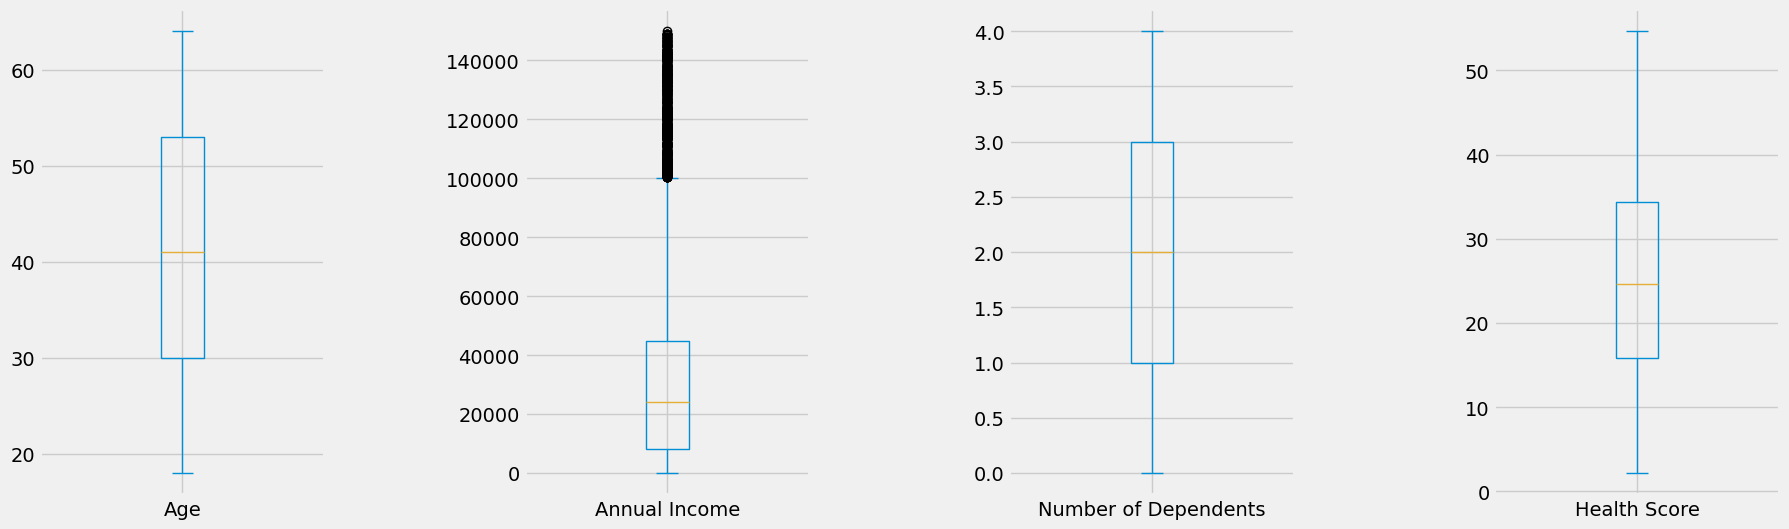

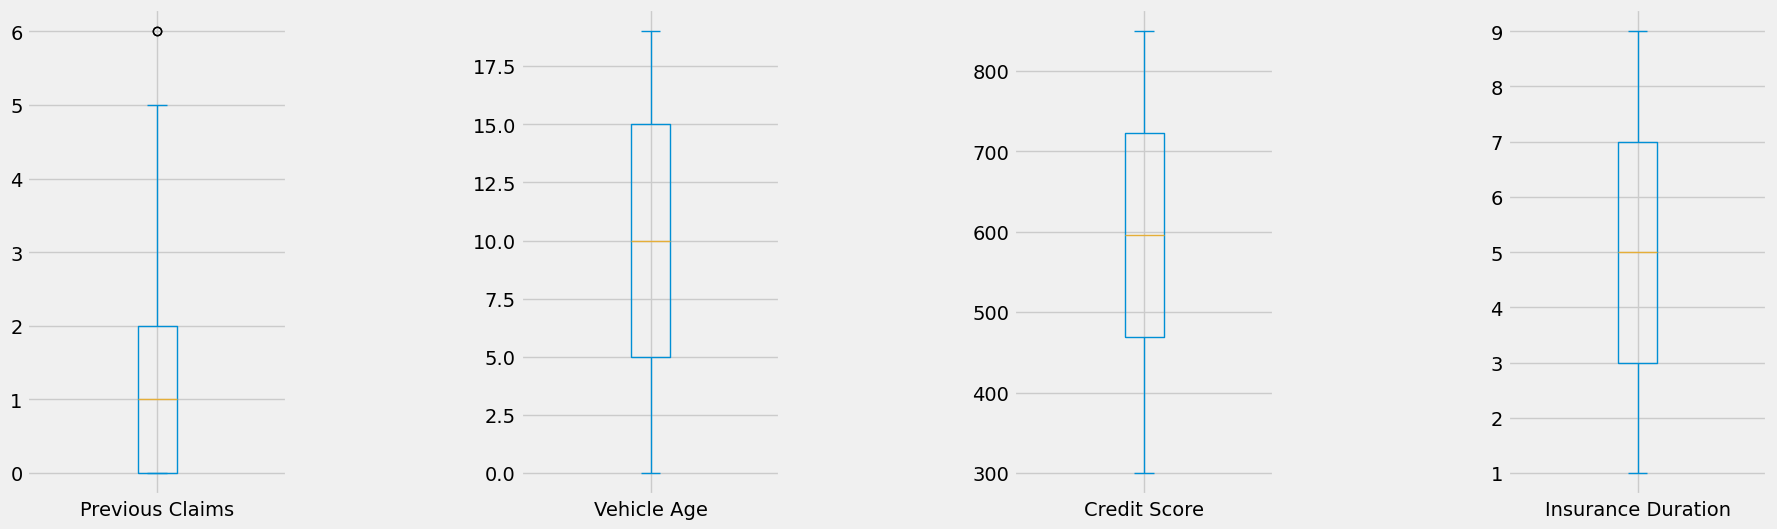

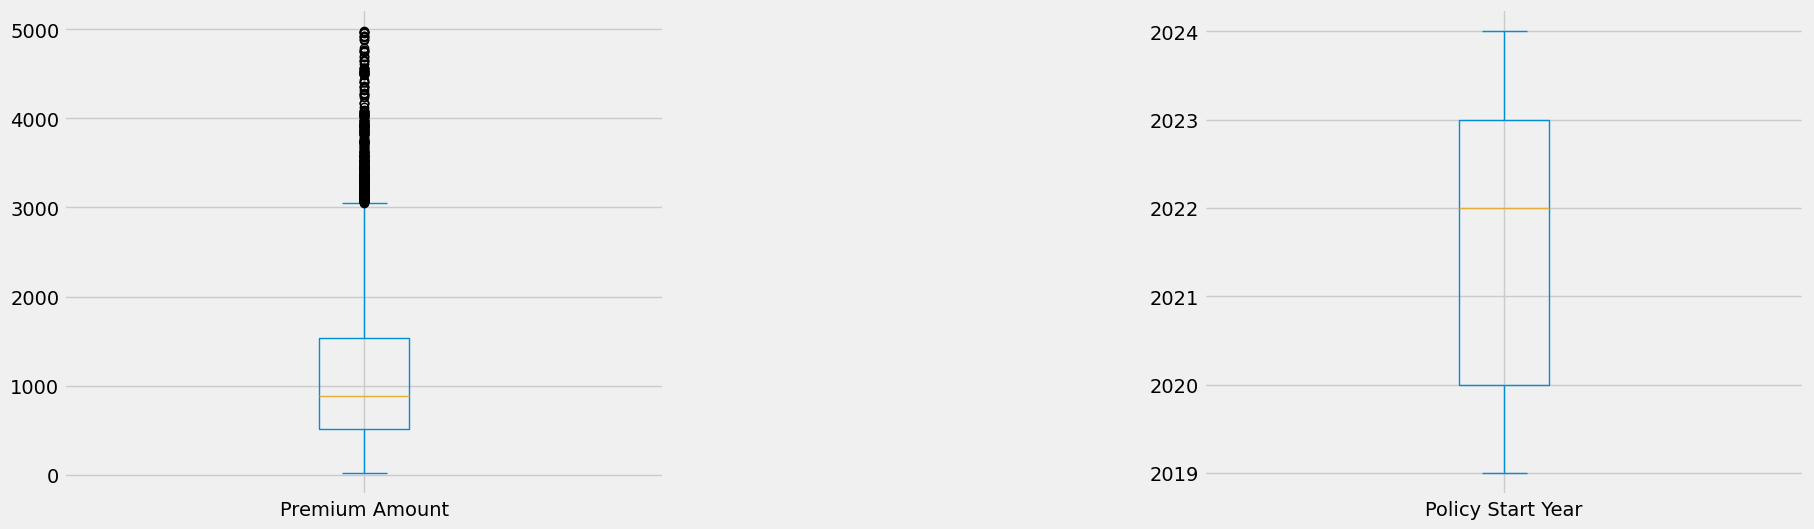

In [438]:
train_df_part.iloc[:,:8].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.7)
train_df_part.iloc[:,8:14].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
train_df_part.iloc[:,14:].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
plt.show()

В столбцах 'Annual Income', 'Previous Claims', 'Premium Amount' можно заметить выбросы. Избавимся от них

In [439]:
def RemoveOutliers(df, column):
    # убираем выбросы
    Q3 = np.quantile(df[column], 0.75, axis=0)
    Q1 = np.quantile(df[column], 0.25, axis=0)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    df[column] = np.where((df[column] > upper), upper, df[column])
    df[column] = np.where((df[column] < lower), lower, df[column])
    return df


for col in ['Annual Income', 'Previous Claims','Premium Amount' ]:
    train_df_part = RemoveOutliers(train_df_part, col)

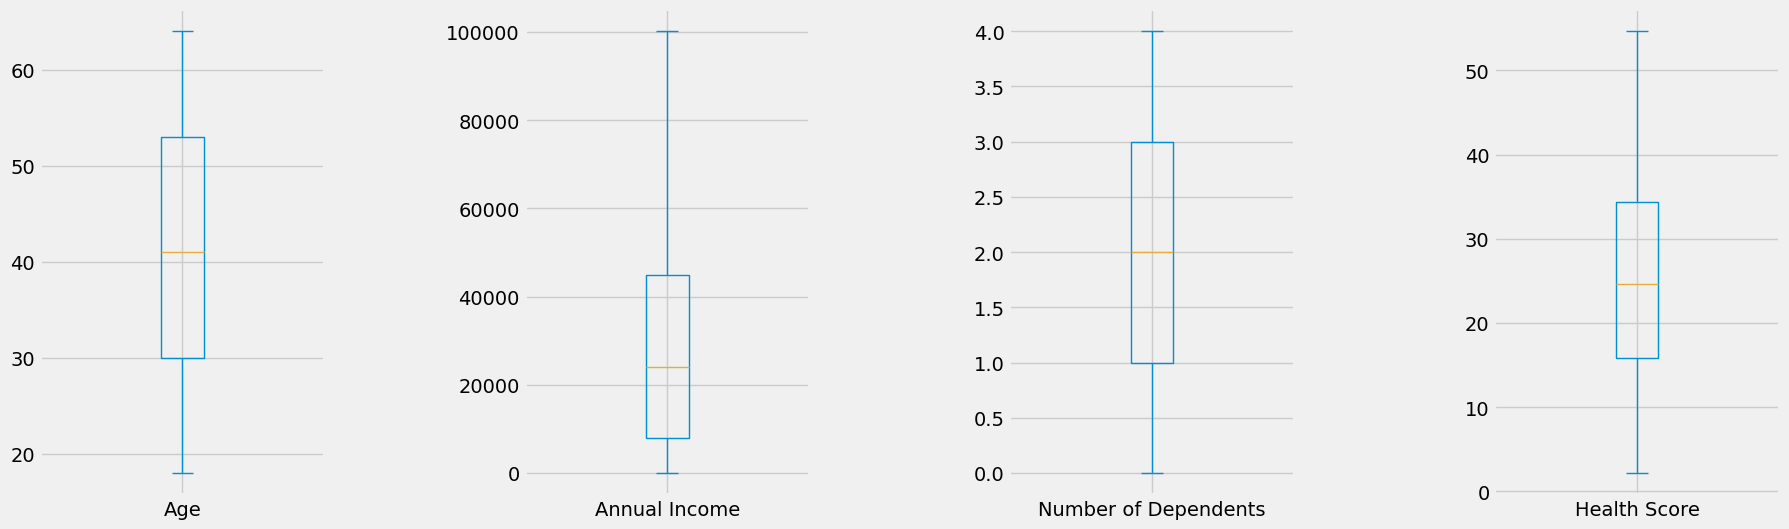

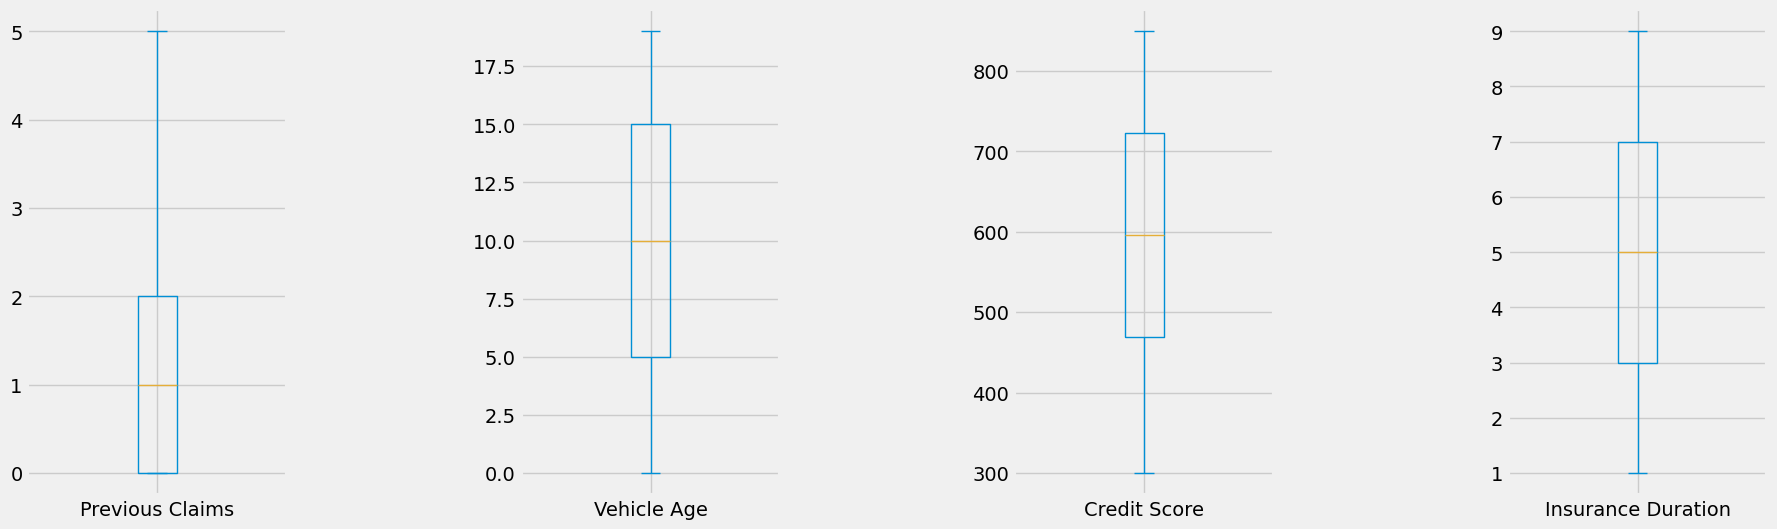

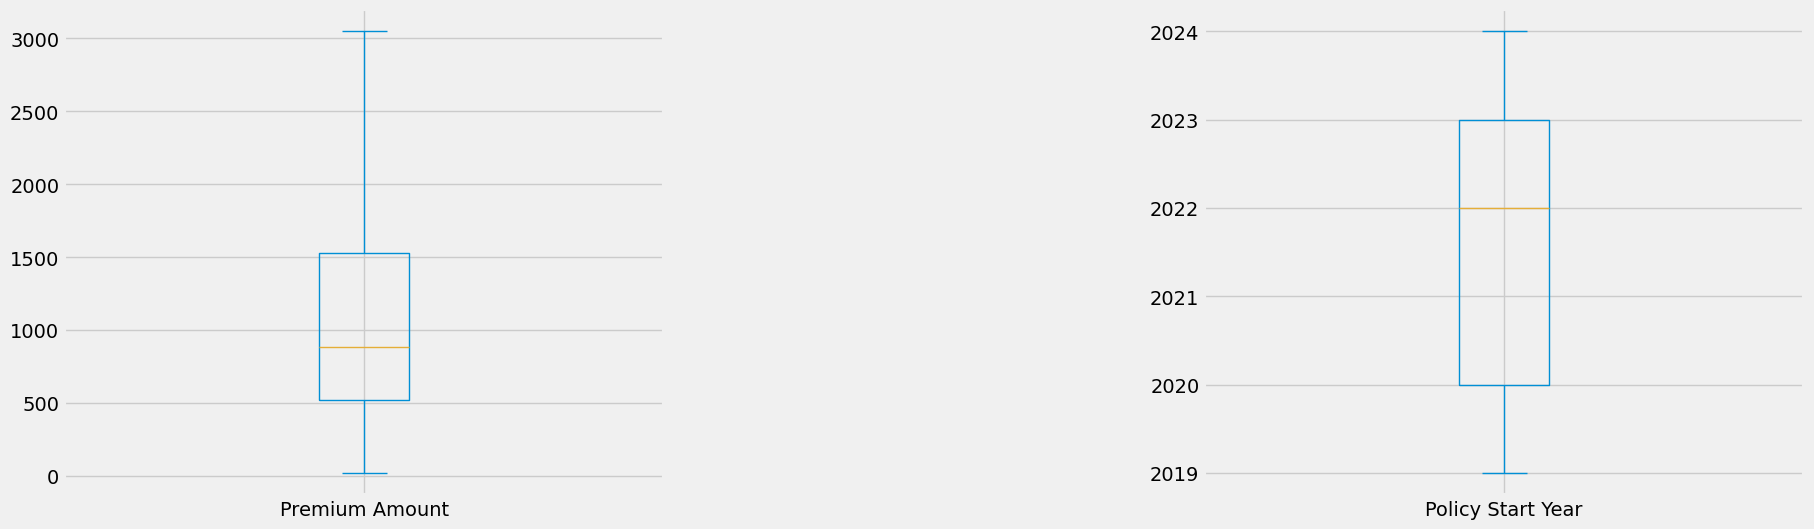

In [440]:
train_df_part.iloc[:,:8].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.7)
train_df_part.iloc[:,8:14].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
train_df_part.iloc[:,14:].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
plt.show()

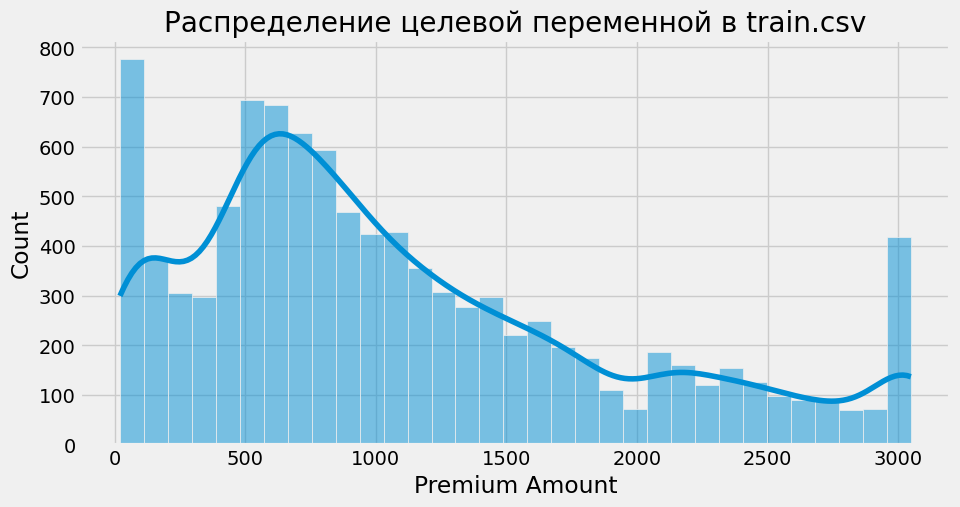

In [441]:
sns.histplot(train_df_part['Premium Amount'], kde=True)
plt.title("Распределение целевой переменной в train.csv")
plt.show()

In [442]:
# посчитаем квантили распределения
train_df_part['Premium Amount'].describe(percentiles=[0.1, 0.25, 0.75, 0.95 ])

count   10,000.00
mean     1,092.47
std        806.40
min         20.00
10%        150.00
25%        519.00
50%        884.00
75%      1,531.00
95%      2,858.05
max      3,049.00
Name: Premium Amount, dtype: float64

In [443]:
train_df_part.describe(include='all')

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Policy Start Year
count,"10,000.00",10000,"10,000.00",10000,"10,000.00",10000,10000,"10,000.00",10000,10000,"10,000.00","10,000.00","10,000.00","10,000.00",10000,10000,10000,10000,"10,000.00","10,000.00"
unique,NaN,2,NaN,3,NaN,4,3,NaN,3,3,NaN,NaN,NaN,NaN,3,2,4,3,NaN,NaN
top,NaN,Male,NaN,Divorced,NaN,PhD,Unemployed,NaN,Suburban,Premium,NaN,NaN,NaN,NaN,Average,No,Monthly,Apartment,NaN,NaN
freq,NaN,5030,NaN,3361,NaN,2590,3359,NaN,3439,3462,NaN,NaN,NaN,NaN,3358,5031,2558,3400,NaN,NaN
mean,41.13,NaN,"31,813.04",NaN,2.01,NaN,NaN,25.50,NaN,NaN,0.98,9.64,594.26,5.00,NaN,NaN,NaN,NaN,"1,092.47","2,021.62"
std,13.54,NaN,"28,859.31",NaN,1.41,NaN,NaN,12.19,NaN,NaN,0.97,5.72,149.25,2.59,NaN,NaN,NaN,NaN,806.40,1.47
min,18.00,NaN,17.00,NaN,0.00,NaN,NaN,2.18,NaN,NaN,0.00,0.00,300.00,1.00,NaN,NaN,NaN,NaN,20.00,"2,019.00"
25%,30.00,NaN,"8,073.75",NaN,1.00,NaN,NaN,15.86,NaN,NaN,0.00,5.00,469.00,3.00,NaN,NaN,NaN,NaN,519.00,"2,020.00"
50%,41.00,NaN,"23,982.00",NaN,2.00,NaN,NaN,24.59,NaN,NaN,1.00,10.00,596.00,5.00,NaN,NaN,NaN,NaN,884.00,"2,022.00"
75%,53.00,NaN,"44,918.00",NaN,3.00,NaN,NaN,34.41,NaN,NaN,2.00,15.00,722.00,7.00,NaN,NaN,NaN,NaN,"1,531.00","2,023.00"


In [444]:
train_df_part.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   10000 non-null  float64
 1   Gender                10000 non-null  object 
 2   Annual Income         10000 non-null  float64
 3   Marital Status        10000 non-null  object 
 4   Number of Dependents  10000 non-null  float64
 5   Education Level       10000 non-null  object 
 6   Occupation            10000 non-null  object 
 7   Health Score          10000 non-null  float64
 8   Location              10000 non-null  object 
 9   Policy Type           10000 non-null  object 
 10  Previous Claims       10000 non-null  float64
 11  Vehicle Age           10000 non-null  float64
 12  Credit Score          10000 non-null  float64
 13  Insurance Duration    10000 non-null  float64
 14  Customer Feedback     10000 non-null  object 
 15  Smoking Status      

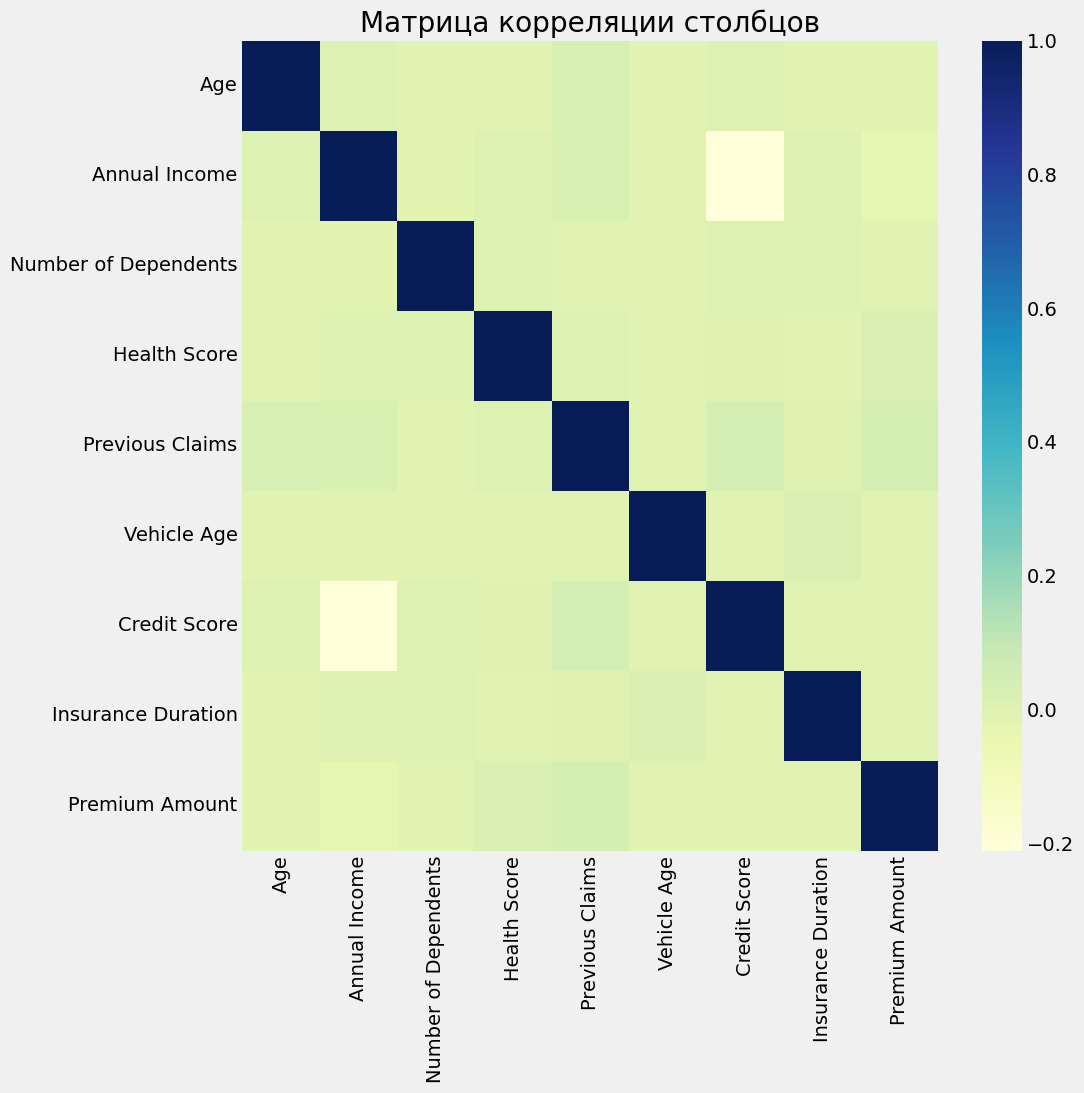

In [447]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(train_df_part[number_col].corr(), cmap="YlGnBu")
plt.title("Матрица корреляции столбцов")
plt.show()

Между столбцами нет сильной корреляции. Нет необходимости какой-либо из них удалять.

Уменьшим размер датасета

In [448]:
int_cols = train_df_part.select_dtypes('int').columns

float_cols = train_df_part.select_dtypes('float').columns
for col in int_cols:
    train_df_part[col] = pd.to_numeric(train_df_part[col], downcast='integer')
for col in float_cols:
    train_df_part[col] = pd.to_numeric(train_df_part[col], downcast='float')

In [449]:
train_df_part.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   10000 non-null  float32
 1   Gender                10000 non-null  object 
 2   Annual Income         10000 non-null  float32
 3   Marital Status        10000 non-null  object 
 4   Number of Dependents  10000 non-null  float32
 5   Education Level       10000 non-null  object 
 6   Occupation            10000 non-null  object 
 7   Health Score          10000 non-null  float32
 8   Location              10000 non-null  object 
 9   Policy Type           10000 non-null  object 
 10  Previous Claims       10000 non-null  float32
 11  Vehicle Age           10000 non-null  float32
 12  Credit Score          10000 non-null  float32
 13  Insurance Duration    10000 non-null  float32
 14  Customer Feedback     10000 non-null  object 
 15  Smoking Status      

# Кодирование категориальных переменных

In [450]:
for col in category_col:
    print(train_df_cat[col].value_counts())
    print("\n")

Gender
Male      5030
Female    4970
Name: count, dtype: int64


Marital Status
Divorced    3361
Single      3338
Married     3301
Name: count, dtype: int64


Education Level
PhD            2590
Master's       2532
Bachelor's     2525
High School    2353
Name: count, dtype: int64


Occupation
Unemployed       3359
Employed         3346
Self-Employed    3295
Name: count, dtype: int64


Location
Suburban    3439
Rural       3318
Urban       3243
Name: count, dtype: int64


Policy Type
Premium          3462
Comprehensive    3270
Basic            3268
Name: count, dtype: int64


Customer Feedback
Average    3358
Good       3349
Poor       3293
Name: count, dtype: int64


Smoking Status
No     5031
Yes    4969
Name: count, dtype: int64


Exercise Frequency
Monthly    2558
Weekly     2517
Rarely     2472
Daily      2453
Name: count, dtype: int64


Property Type
Apartment    3400
Condo        3323
House        3277
Name: count, dtype: int64


Policy Start Year
2022    2060
2020    2038
2023  

In [451]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
sex = encoder.fit_transform(train_df_part['Gender'])
encoded_df = train_df_part.drop("Gender", axis=1)
encoded_df['Gender'] = sex
encoded_df

,Age,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Policy Start Year,Gender
0,43.00,"5,813.00",Divorced,2.00,Bachelor's,Unemployed,29.44,Urban,Comprehensive,1.00,13.00,748.00,5.00,Poor,Yes,Weekly,Apartment,837.00,2024,0
1,30.00,"81,659.00",Married,0.00,Bachelor's,Employed,34.99,Suburban,Comprehensive,2.00,1.00,505.00,3.00,Average,No,Monthly,Condo,435.00,2021,0
2,62.00,"18,031.00",Married,2.00,Master's,Unemployed,5.29,Suburban,Premium,0.00,12.00,467.00,6.00,Average,No,Monthly,Apartment,959.00,2020,1
3,39.00,"30,333.00",Single,1.00,Bachelor's,Employed,47.93,Urban,Basic,2.00,2.00,478.00,2.00,Average,Yes,Monthly,House,839.00,2023,1
4,58.00,"7,876.00",Single,2.00,High School,Employed,27.91,Rural,Premium,1.00,14.00,616.00,4.00,Poor,Yes,Daily,Apartment,557.00,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,40.00,"33,754.00",Divorced,1.00,Bachelor's,Self-Employed,32.46,Rural,Premium,0.00,11.00,727.00,6.00,Good,Yes,Rarely,Condo,"1,269.00",2020,0
9996,19.00,"70,737.00",Divorced,3.00,Bachelor's,Unemployed,19.78,Rural,Basic,2.00,9.00,469.00,5.00,Good,No,Rarely,Apartment,119.00,2023,1
9997,59.00,"1,585.00",Married,2.00,High School,Self-Employed,27.38,Urban,Premium,3.00,5.00,500.00,2.00,Good,No,Monthly,Condo,212.00,2023,1
9998,57.00,"17,054.00",Divorced,3.00,High School,Self-Employed,12.54,Urban,Comprehensive,0.00,9.00,656.00,8.00,Good,No,Rarely,Apartment,"1,288.00",2020,1


In [452]:
smoke = encoder.fit_transform(encoded_df['Smoking Status'])
encoded_df = encoded_df.drop("Smoking Status", axis=1)
encoded_df['Smoking Status'] = smoke
encoded_df

,Age,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Exercise Frequency,Property Type,Premium Amount,Policy Start Year,Gender,Smoking Status
0,43.00,"5,813.00",Divorced,2.00,Bachelor's,Unemployed,29.44,Urban,Comprehensive,1.00,13.00,748.00,5.00,Poor,Weekly,Apartment,837.00,2024,0,1
1,30.00,"81,659.00",Married,0.00,Bachelor's,Employed,34.99,Suburban,Comprehensive,2.00,1.00,505.00,3.00,Average,Monthly,Condo,435.00,2021,0,0
2,62.00,"18,031.00",Married,2.00,Master's,Unemployed,5.29,Suburban,Premium,0.00,12.00,467.00,6.00,Average,Monthly,Apartment,959.00,2020,1,0
3,39.00,"30,333.00",Single,1.00,Bachelor's,Employed,47.93,Urban,Basic,2.00,2.00,478.00,2.00,Average,Monthly,House,839.00,2023,1,1
4,58.00,"7,876.00",Single,2.00,High School,Employed,27.91,Rural,Premium,1.00,14.00,616.00,4.00,Poor,Daily,Apartment,557.00,2023,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,40.00,"33,754.00",Divorced,1.00,Bachelor's,Self-Employed,32.46,Rural,Premium,0.00,11.00,727.00,6.00,Good,Rarely,Condo,"1,269.00",2020,0,1
9996,19.00,"70,737.00",Divorced,3.00,Bachelor's,Unemployed,19.78,Rural,Basic,2.00,9.00,469.00,5.00,Good,Rarely,Apartment,119.00,2023,1,0
9997,59.00,"1,585.00",Married,2.00,High School,Self-Employed,27.38,Urban,Premium,3.00,5.00,500.00,2.00,Good,Monthly,Condo,212.00,2023,1,0
9998,57.00,"17,054.00",Divorced,3.00,High School,Self-Employed,12.54,Urban,Comprehensive,0.00,9.00,656.00,8.00,Good,Rarely,Apartment,"1,288.00",2020,1,0


In [453]:
person_education_map = {'High School' : 0, "Bachelor's" : 1, "Master's" : 2,'PhD' : 3}
encoded_df['Education Level'] = encoded_df['Education Level'].map(person_education_map)
encoded_df

,Age,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Exercise Frequency,Property Type,Premium Amount,Policy Start Year,Gender,Smoking Status
0,43.00,"5,813.00",Divorced,2.00,1,Unemployed,29.44,Urban,Comprehensive,1.00,13.00,748.00,5.00,Poor,Weekly,Apartment,837.00,2024,0,1
1,30.00,"81,659.00",Married,0.00,1,Employed,34.99,Suburban,Comprehensive,2.00,1.00,505.00,3.00,Average,Monthly,Condo,435.00,2021,0,0
2,62.00,"18,031.00",Married,2.00,2,Unemployed,5.29,Suburban,Premium,0.00,12.00,467.00,6.00,Average,Monthly,Apartment,959.00,2020,1,0
3,39.00,"30,333.00",Single,1.00,1,Employed,47.93,Urban,Basic,2.00,2.00,478.00,2.00,Average,Monthly,House,839.00,2023,1,1
4,58.00,"7,876.00",Single,2.00,0,Employed,27.91,Rural,Premium,1.00,14.00,616.00,4.00,Poor,Daily,Apartment,557.00,2023,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,40.00,"33,754.00",Divorced,1.00,1,Self-Employed,32.46,Rural,Premium,0.00,11.00,727.00,6.00,Good,Rarely,Condo,"1,269.00",2020,0,1
9996,19.00,"70,737.00",Divorced,3.00,1,Unemployed,19.78,Rural,Basic,2.00,9.00,469.00,5.00,Good,Rarely,Apartment,119.00,2023,1,0
9997,59.00,"1,585.00",Married,2.00,0,Self-Employed,27.38,Urban,Premium,3.00,5.00,500.00,2.00,Good,Monthly,Condo,212.00,2023,1,0
9998,57.00,"17,054.00",Divorced,3.00,0,Self-Employed,12.54,Urban,Comprehensive,0.00,9.00,656.00,8.00,Good,Rarely,Apartment,"1,288.00",2020,1,0


In [454]:
for col in ['Gender','Education Level','Smoking Status']:
    category_col.remove(col)
category_col

['Marital Status',
 'Occupation',
 'Location',
 'Policy Type',
 'Customer Feedback',
 'Exercise Frequency',
 'Property Type',
 'Policy Start Year']

In [455]:
df_pandas_encoded = pd.get_dummies(encoded_df, columns=category_col, drop_first=True, dtype=int)
df_pandas_encoded

,Age,Annual Income,Number of Dependents,Education Level,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,...,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House,Policy Start Year_2020,Policy Start Year_2021,Policy Start Year_2022,Policy Start Year_2023,Policy Start Year_2024
0,43.00,"5,813.00",2.00,1,29.44,1.00,13.00,748.00,5.00,837.00,...,0,0,1,0,0,0,0,0,0,1
1,30.00,"81,659.00",0.00,1,34.99,2.00,1.00,505.00,3.00,435.00,...,1,0,0,1,0,0,1,0,0,0
2,62.00,"18,031.00",2.00,2,5.29,0.00,12.00,467.00,6.00,959.00,...,1,0,0,0,0,1,0,0,0,0
3,39.00,"30,333.00",1.00,1,47.93,2.00,2.00,478.00,2.00,839.00,...,1,0,0,0,1,0,0,0,1,0
4,58.00,"7,876.00",2.00,0,27.91,1.00,14.00,616.00,4.00,557.00,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,40.00,"33,754.00",1.00,1,32.46,0.00,11.00,727.00,6.00,"1,269.00",...,0,1,0,1,0,1,0,0,0,0
9996,19.00,"70,737.00",3.00,1,19.78,2.00,9.00,469.00,5.00,119.00,...,0,1,0,0,0,0,0,0,1,0
9997,59.00,"1,585.00",2.00,0,27.38,3.00,5.00,500.00,2.00,212.00,...,1,0,0,1,0,0,0,0,1,0
9998,57.00,"17,054.00",3.00,0,12.54,0.00,9.00,656.00,8.00,"1,288.00",...,0,1,0,0,0,1,0,0,0,0


# Обучение моделей

In [456]:
X = df_pandas_encoded.drop('Premium Amount', axis=1)
Y = df_pandas_encoded['Premium Amount']

In [457]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RAND_STATE)

In [458]:
# словарь для оценок качества моделей
regression_error = {}

## Модель RandomForestRegressor

In [418]:
regressor_tree = RandomForestRegressor(random_state=RAND_STATE)
regressor_tree.fit(X_train, y_train)
Y_pred_test = regressor_tree.predict(X_test)
regression_error['RandomForestRegressor'] = {"RMSE":root_mean_squared_error(y_test, Y_pred_test),"MSE":mean_squared_error(y_test, Y_pred_test), "MAE": mean_absolute_error(y_test, Y_pred_test),"R2": r2_score(y_test, Y_pred_test) }

In [419]:
regression_error['RandomForestRegressor']

{'RMSE': 828.7916050015831,
 'MSE': 686895.5245211001,
 'MAE': 661.3319299999999,
 'R2': -0.008301366719803527}

Модель не самого хорошего качества.

## tsfresh

In [399]:
X['id'] = X.index

In [400]:
X

,Age,Annual Income,Number of Dependents,Education Level,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Gender,...,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House,Policy Start Year_2020,Policy Start Year_2021,Policy Start Year_2022,Policy Start Year_2023,Policy Start Year_2024,id
0,43.00,"5,813.00",2.00,1,29.44,1.00,13.00,748.00,5.00,0,...,0,1,0,0,0,0,0,0,1,0
1,30.00,"81,659.00",0.00,1,34.99,2.00,1.00,505.00,3.00,0,...,0,0,1,0,0,1,0,0,0,1
2,62.00,"18,031.00",2.00,2,5.29,0.00,12.00,467.00,6.00,1,...,0,0,0,0,1,0,0,0,0,2
3,39.00,"30,333.00",1.00,1,47.93,2.00,2.00,478.00,2.00,1,...,0,0,0,1,0,0,0,1,0,3
4,58.00,"7,876.00",2.00,0,27.91,1.00,14.00,616.00,4.00,1,...,0,0,0,0,0,0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,40.00,"33,754.00",1.00,1,32.46,0.00,11.00,727.00,6.00,0,...,1,0,1,0,1,0,0,0,0,9995
9996,19.00,"70,737.00",3.00,1,19.78,2.00,9.00,469.00,5.00,1,...,1,0,0,0,0,0,0,1,0,9996
9997,59.00,"1,585.00",2.00,0,27.38,3.00,5.00,500.00,2.00,1,...,0,0,1,0,0,0,0,1,0,9997
9998,57.00,"17,054.00",3.00,0,12.54,0.00,9.00,656.00,8.00,1,...,1,0,0,0,1,0,0,0,0,9998


In [401]:
all_features = extract_features(X, 
                                column_id="id",
                                      n_jobs=4, disable_progressbar=False,
                                      default_fc_parameters=MinimalFCParameters(),
                                      impute_function=None)

Feature Extraction: 100%|██████████| 20/20 [00:26<00:00,  1.35s/it]


In [402]:
all_features

,Age__sum_values,Age__median,Age__mean,Age__length,Age__standard_deviation,Age__variance,Age__root_mean_square,Age__maximum,Age__absolute_maximum,Age__minimum,...,Policy Start Year_2024__sum_values,Policy Start Year_2024__median,Policy Start Year_2024__mean,Policy Start Year_2024__length,Policy Start Year_2024__standard_deviation,Policy Start Year_2024__variance,Policy Start Year_2024__root_mean_square,Policy Start Year_2024__maximum,Policy Start Year_2024__absolute_maximum,Policy Start Year_2024__minimum
0,43.00,43.00,43.00,1.00,0.00,0.00,43.00,43.00,43.00,43.00,...,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00
1,30.00,30.00,30.00,1.00,0.00,0.00,30.00,30.00,30.00,30.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,62.00,62.00,62.00,1.00,0.00,0.00,62.00,62.00,62.00,62.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
3,39.00,39.00,39.00,1.00,0.00,0.00,39.00,39.00,39.00,39.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,58.00,58.00,58.00,1.00,0.00,0.00,58.00,58.00,58.00,58.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,40.00,40.00,40.00,1.00,0.00,0.00,40.00,40.00,40.00,40.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
9996,19.00,19.00,19.00,1.00,0.00,0.00,19.00,19.00,19.00,19.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
9997,59.00,59.00,59.00,1.00,0.00,0.00,59.00,59.00,59.00,59.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
9998,57.00,57.00,57.00,1.00,0.00,0.00,57.00,57.00,57.00,57.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00


In [403]:
all_features.columns

Index(['Age__sum_values', 'Age__median', 'Age__mean', 'Age__length',
       'Age__standard_deviation', 'Age__variance', 'Age__root_mean_square',
       'Age__maximum', 'Age__absolute_maximum', 'Age__minimum',
       ...
       'Policy Start Year_2024__sum_values', 'Policy Start Year_2024__median',
       'Policy Start Year_2024__mean', 'Policy Start Year_2024__length',
       'Policy Start Year_2024__standard_deviation',
       'Policy Start Year_2024__variance',
       'Policy Start Year_2024__root_mean_square',
       'Policy Start Year_2024__maximum',
       'Policy Start Year_2024__absolute_maximum',
       'Policy Start Year_2024__minimum'],
      dtype='object', length=310)

Исключии столбцы со значениями NaN и большим числом нулевых значений (больше половины столбца)

In [404]:
for col in all_features.columns:
    if all_features[col].isna().sum() > 0:
        print(f'{col} есть Null')
        all_features = all_features.drop(col, axis=1)
    if (all_features[col] == 0).sum() / len(all_features[col]) > 0.5:
        print(f'{col} больше половины 0')
        all_features = all_features.drop(col, axis=1)

Age__standard_deviation больше половины 0
Age__variance больше половины 0
Annual Income__standard_deviation больше половины 0
Annual Income__variance больше половины 0
Number of Dependents__standard_deviation больше половины 0
Number of Dependents__variance больше половины 0
Education Level__standard_deviation больше половины 0
Education Level__variance больше половины 0
Health Score__standard_deviation больше половины 0
Health Score__variance больше половины 0
Previous Claims__standard_deviation больше половины 0
Previous Claims__variance больше половины 0
Vehicle Age__standard_deviation больше половины 0
Vehicle Age__variance больше половины 0
Credit Score__standard_deviation больше половины 0
Credit Score__variance больше половины 0
Insurance Duration__standard_deviation больше половины 0
Insurance Duration__variance больше половины 0
Gender__standard_deviation больше половины 0
Gender__variance больше половины 0
Smoking Status__sum_values больше половины 0
Smoking Status__median бо

In [405]:
all_features

,Age__sum_values,Age__median,Age__mean,Age__length,Age__root_mean_square,Age__maximum,Age__absolute_maximum,Age__minimum,Annual Income__sum_values,Annual Income__median,...,Exercise Frequency_Monthly__length,Exercise Frequency_Rarely__length,Exercise Frequency_Weekly__length,Property Type_Condo__length,Property Type_House__length,Policy Start Year_2020__length,Policy Start Year_2021__length,Policy Start Year_2022__length,Policy Start Year_2023__length,Policy Start Year_2024__length
0,43.00,43.00,43.00,1.00,43.00,43.00,43.00,43.00,"5,813.00","5,813.00",...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,30.00,30.00,30.00,1.00,30.00,30.00,30.00,30.00,"81,659.00","81,659.00",...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2,62.00,62.00,62.00,1.00,62.00,62.00,62.00,62.00,"18,031.00","18,031.00",...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
3,39.00,39.00,39.00,1.00,39.00,39.00,39.00,39.00,"30,333.00","30,333.00",...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
4,58.00,58.00,58.00,1.00,58.00,58.00,58.00,58.00,"7,876.00","7,876.00",...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,40.00,40.00,40.00,1.00,40.00,40.00,40.00,40.00,"33,754.00","33,754.00",...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9996,19.00,19.00,19.00,1.00,19.00,19.00,19.00,19.00,"70,737.00","70,737.00",...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9997,59.00,59.00,59.00,1.00,59.00,59.00,59.00,59.00,"1,585.00","1,585.00",...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9998,57.00,57.00,57.00,1.00,57.00,57.00,57.00,57.00,"17,054.00","17,054.00",...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [406]:
features_filtered = select_features(all_features, Y) # Выбор наиболее подходящих признаков

In [407]:
features_filtered

,Annual Income__sum_values,Annual Income__root_mean_square,Annual Income__minimum,Annual Income__absolute_maximum,Annual Income__maximum,Annual Income__median,Annual Income__mean
0,"5,813.00","5,813.00","5,813.00","5,813.00","5,813.00","5,813.00","5,813.00"
1,"81,659.00","81,659.00","81,659.00","81,659.00","81,659.00","81,659.00","81,659.00"
2,"18,031.00","18,031.00","18,031.00","18,031.00","18,031.00","18,031.00","18,031.00"
3,"30,333.00","30,333.00","30,333.00","30,333.00","30,333.00","30,333.00","30,333.00"
4,"7,876.00","7,876.00","7,876.00","7,876.00","7,876.00","7,876.00","7,876.00"
...,...,...,...,...,...,...,...
9995,"33,754.00","33,754.00","33,754.00","33,754.00","33,754.00","33,754.00","33,754.00"
9996,"70,737.00","70,737.00","70,737.00","70,737.00","70,737.00","70,737.00","70,737.00"
9997,"1,585.00","1,585.00","1,585.00","1,585.00","1,585.00","1,585.00","1,585.00"
9998,"17,054.00","17,054.00","17,054.00","17,054.00","17,054.00","17,054.00","17,054.00"


In [408]:
relevant_features = extract_relevant_features(
    X,
    Y,
    column_id='id',
    default_fc_parameters=MinimalFCParameters()
)

Feature Extraction: 100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


In [409]:
relevant_features.head()

,Annual Income__sum_values,Annual Income__root_mean_square,Annual Income__minimum,Annual Income__absolute_maximum,Annual Income__maximum,Annual Income__median,Annual Income__mean
0,"5,813.00","5,813.00","5,813.00","5,813.00","5,813.00","5,813.00","5,813.00"
1,"81,659.00","81,659.00","81,659.00","81,659.00","81,659.00","81,659.00","81,659.00"
2,"18,031.00","18,031.00","18,031.00","18,031.00","18,031.00","18,031.00","18,031.00"
3,"30,333.00","30,333.00","30,333.00","30,333.00","30,333.00","30,333.00","30,333.00"
4,"7,876.00","7,876.00","7,876.00","7,876.00","7,876.00","7,876.00","7,876.00"


In [410]:
# Обучение модели на релевантных признаках
X_train_relevant, X_test_relevant, y_train, y_test = train_test_split(relevant_features, Y, test_size=TEST_SIZE, random_state=RAND_STATE)

In [420]:
regressor_tree = RandomForestRegressor(random_state=RAND_STATE)
regressor_tree.fit(X_train_relevant, y_train)
Y_pred_test = regressor_tree.predict(X_test_relevant)
regression_error['RandomForestRegressor with tsfresh'] = {"RMSE":root_mean_squared_error(y_test, Y_pred_test),"MSE":mean_squared_error(y_test, Y_pred_test), "MAE": mean_absolute_error(y_test, Y_pred_test),"R2": r2_score(y_test, Y_pred_test) }

In [421]:
pd.options.display.float_format = '{:,.5f}'.format
regression_error_df = pd.DataFrame(regression_error)
regression_error_df

,RandomForestRegressor,RandomForestRegressor with tsfresh
RMSE,828.79161,978.95419
MSE,"686,895.52452","958,351.31400"
MAE,661.33193,757.35171
R2,-0.00830,-0.40677


Качество модели с подбором признаков tsfresh ухудшилось.

In [413]:
# Получение важности признаков
importances = regressor_tree.feature_importances_
importances

array([0.14241037, 0.14282291, 0.14275903, 0.14413919, 0.14308461,
       0.14127996, 0.14350392])

In [414]:
# Сортировка индексов
sorted_indices = importances.argsort()[::-1]
sorted_indices

array([3, 6, 4, 1, 2, 0, 5])

In [415]:
feat_labels = X_train.columns
results = pd.DataFrame(columns=["Column", "Importance"])

# Определение минимальной длины между размером X и длиной sorted_indices
n_features = min(X_train.shape[1], len(sorted_indices), len(importances))

for f in range(n_features):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))
    results.loc[len(results)] = {
        "Column": feat_labels[sorted_indices[f]],
        "Importance": importances[sorted_indices[f]]
    }

 1) Education Level                0.144139
 2) Vehicle Age                    0.143504
 3) Health Score                   0.143085
 4) Annual Income                  0.142823
 5) Number of Dependents           0.142759
 6) Age                            0.142410
 7) Previous Claims                0.141280


In [416]:
plt.rcParams["figure.figsize"] = (20,10) # размер графиков

plt.style.use('fivethirtyeight') # стиль графиков

# Отображение результатов в виде бара с использованием Plotly Express
fig = px.bar(results[:15],
             x="Column",
             y="Importance",
             title='Важность признаков',
             labels={'x': 'Признаки', 'y': 'Важность признаков'},
             color_discrete_sequence=['#636EFA'])

# Настройка отображения графика
fig.update_layout(
    barmode='group',
    xaxis_title=None,
    yaxis_title=None,
    legend_title=None,
    hovermode='x unified',
    margin=dict(b=100),
    height=600
)

# Отображение графика
fig.show()

Столбец Education Level больше всего влияет на модель.